<a href="https://colab.research.google.com/github/DanielZafra4/CienciadeDatosIII/blob/main/Entrega_Final_DSIII_Zafra_Daniel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Análisis de Sentimiento en Reseñas en Español mediante Procesamiento de Lenguaje Natural y Modelos de Aprendizaje Automático**

##**Abstract**
Este proyecto tiene como objetivo desarrollar un modelo de Deep Learning capaz de automatizar el análisis de sentimientos en críticas de cine escritas en español, clasificando la polaridad de las reseñas como positivas o negativas.

El análisis se basa en el dataset **“Críticas de Películas Filmaffinity en Español (Netflix)”**, obtenido de la plataforma Kaggle (https://www.kaggle.com/datasets/andrsmosquera/crticas-pelculas-filmaffinity-en-espaol-netflix).

Este conjunto de datos fue creado con el propósito de fomentar el desarrollo de recursos de Procesamiento de Lenguaje Natural (NLP) en español, un idioma que aún cuenta con menor disponibilidad de herramientas que el inglés en este campo. El dataset contiene reseñas y calificaciones otorgadas por usuarios del sitio *Filmaffinity*

##**Librerías**

In [26]:
# Librerías necesarias para el análisis y visualización
import pandas as pd              # Manejo de datos
import numpy as np               # Operaciones numéricas
import re                        # Expresiones regulares
import spacy                     # Procesamiento del lenguaje natural
import matplotlib.pyplot as plt  # Visualización de datos
from wordcloud import WordCloud  # Generación de nubes de palabra
from collections import Counter  # Conteo de palabras y creación de n-gramas

# Librerías de Machine Learning
from sklearn.model_selection import train_test_split                            # División del dataset en entrenamiento y prueba
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer    # Vectorización del texto (BoW y TF-IDF)
from sklearn.linear_model import LogisticRegression                             # Modelo de clasificación supervisado
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay  # Evaluación del modelo

# Librerías de Deep Learning (Keras / TensorFlow)
from tensorflow.keras.preprocessing.text import Tokenizer            # Tokenización de texto para redes neuronales
from tensorflow.keras.preprocessing.sequence import pad_sequences    # Padding de secuencias para entrada uniforme
from tensorflow.keras.models import Sequential                       # Creación de modelo secuencial
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout  # Capas del modelo LSTM
from tensorflow.keras.optimizers import Adam                         # Optimizador Adam para el entrenamiento del modelo
from keras.callbacks import EarlyStopping                            # Callback para detener el entrenamiento cuando no mejora
from keras.optimizers import Adam                                    # Optimizador (reimportado por compatibilidad)


## **Carga y Exploración Inicial del Dataset**

En esta sección se realiza la lectura del dataset directamente desde el repositorio de GitHub. Posteriormente, se lleva a cabo una exploración inicial para verificar la correcta carga de los datos, su estructura, los tipos de variables y la presencia de valores nulos.

In [2]:
# URL del archivo de Excel en el repositorio de GitHub
url = 'https://raw.githubusercontent.com/DanielZafra4/CienciadeDatosIII/main/film_reviews_result.xlsx'
# Cargar el archivo de Excel
data = pd.read_excel(url, engine='openpyxl') # Se especifica el motor 'openpyxl' para la lectura de archivos .xlsx
display(data.head(20))

,film_name,gender,film_avg_rate,review_rate,review_title,review_text
0,Respira (Serie de TV),"Serie de TV, Drama, Medicina",4.6,1,Respira,"Como fan de las series espaÃ±olas y de Najwa, ..."
1,Respira (Serie de TV),"Serie de TV, Drama, Medicina",4.6,2,Esta serie te llama tonto a la cara,Todo lo malo que puede tener una serie lo pose...
2,Respira (Serie de TV),"Serie de TV, Drama, Medicina",4.6,1,Respira,"La serie es un drama mÃ©dico que intenta ""copi..."
3,Respira (Serie de TV),"Serie de TV, Drama, Medicina",4.6,1,"Imposible, no hay manera",Nadie te obliga a ver nada que no quieras ver ...
4,Respira (Serie de TV),"Serie de TV, Drama, Medicina",4.6,1,Serie nefasta,EstÃ¡ serie da vergÃ¼enza ajena. Una serie don...
5,Respira (Serie de TV),"Serie de TV, Drama, Medicina",4.6,5,Elitizando un hospital,PuntuaciÃ³n: â­ï¸â­ï¸ de 5Elitizando un ho...
6,Respira (Serie de TV),"Serie de TV, Drama, Medicina",4.6,3,CrÃ­tica de Respira por Cinemagavia,*Una serie que lucha por capturar la realidad ...
7,Respira (Serie de TV),"Serie de TV, Drama, Medicina",4.6,6,"MÃ©dicos, relojes y actualidad",Puede que no sea fiel ni a la realidad de los ...
8,Respira (Serie de TV),"Serie de TV, Drama, Medicina",4.6,4,PequeÃ±a sorpresa en la sanidad valenciana,La crÃ­tica se limita a su primera temporada. ...
9,Respira (Serie de TV),"Serie de TV, Drama, Medicina",4.6,6,No es tan mala como la ponen,Es una serie para entretener un rato sin mayor...


In [3]:
# Información general del dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8787 entries, 0 to 8786
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   film_name      8787 non-null   object 
 1   gender         8787 non-null   object 
 2   film_avg_rate  8787 non-null   float64
 3   review_rate    8787 non-null   int64  
 4   review_title   8787 non-null   object 
 5   review_text    8787 non-null   object 
dtypes: float64(1), int64(1), object(4)
memory usage: 412.0+ KB


## **Definición de las Variables**

El dataset contiene 8787 registros y 6 variables que describen diferentes aspectos de las reseñas publicadas por usuarios de Filmaffinity.
A continuación se detalla la función de cada variable:

*   **film_name:** nombre de la película o serie a la que pertenece la reseña. Corresponde al título principal de la obra audiovisual.
*   **gender:** géneros cinematográficos asociados a la película o serie (por ejemplo, Drama, Comedia, Ciencia ficción). Puede contener múltiples géneros separados por comas.
*   **film_avg_rate:** puntuación promedio general de la película o serie en Filmaffinity. Se expresa en una escala numérica del 1 al 10, con valores decimales.
*   **review_rate: **puntuación otorgada por el usuario en la reseña específica. Se representa mediante un valor entero entre 1 (muy negativa) y 10 (muy positiva).

*   **review_title:** título breve que el usuario asigna a su reseña. Generalmente resume la opinión o el sentimiento principal.
*   **review_text:** texto completo de la reseña escrita por el usuario. Es la variable de interés para el análisis de sentimientos, ya que contiene la información textual que será procesada mediante técnicas de NLP.














### **Análisis de la Información Técnica y Estructural**
Tras la ejecución del código de carga, se obtienen los resultados que permiten evaluar la calidad y la estructura del dataset antes de iniciar el preprocesamiento de texto.

Un aspecto relevante es que la columna Non-Null Count indica que no existen valores nulos en ninguna de las variables. Esto significa que el dataset presenta una integridad completa, por lo que no será necesario aplicar técnicas de imputación ni eliminar filas por datos faltantes.

En cuanto a los tipos de datos, se verifica que están correctamente definidos:


*   Las variables textuales (*film_name, gender, review_title, review_text*) son de tipo object, lo cual es adecuado para su tratamiento mediante técnicas de NLP.
*   Las variables numéricas (*film_avg_rate y review_rate*) están definidas como float64 e int64, respectivamente, lo que resulta apropiado para futuros análisis estadísticos o de clasificación.

Sin embargo, a pesar de la integridad estructural, la inspección visual mediante data.head() revela un problema de codificación de caracteres.
Se observan secuencias incorrectas como **Ã±, Ã³, Ã**­, que sustituyen caracteres propios del idioma español, como la ñ o las vocales acentuadas.

Este error, probablemente derivado de una inconsistencia entre los estándares UTF-8 e ISO-8859-1 durante la descarga o guardado del archivo, debe corregirse antes de continuar con el preprocesamiento lingüístico.
De no hacerlo, palabras como “españolas” serían interpretadas como “espaÃ±olas”, lo cual afectaría la tokenización, la lematización y cualquier análisis semántico posterior.

## **Etapa 1**

### **ETAPA 1.1: Limpieza Inicial**
Con base en la inspección visual y técnica, se inicia la primera fase del desarrollo, centrada en preparar los datos para el modelado posterior de Deep Learning.

#### **1. Estandarización de Nombres de Columnas**
Se renombran las columnas del DataFrame para que los nombres sean más claros, descriptivos y consistentes con el idioma del proyecto. Esto mejora la legibilidad, la documentación y el mantenimiento del código.

In [4]:
# Renombrar columnas
new_column_names = {
    'film_name': 'Nombre',
    'gender': 'Genero',
    'film_avg_rate': 'Calificacion_promedio',
    'review_rate': 'Calificacion_reseña',
    'review_title': 'Titulo_reseña',
    'review_text': 'Reseña'
}

data = data.rename(columns=new_column_names)
print("--- DataFrame con Nombres de Columnas Estandarizados ---")
display(data.head())

--- DataFrame con Nombres de Columnas Estandarizados ---


,Nombre,Genero,Calificacion_promedio,Calificacion_reseña,Titulo_reseña,Reseña
0,Respira (Serie de TV),"Serie de TV, Drama, Medicina",4.6,1,Respira,"Como fan de las series espaÃ±olas y de Najwa, ..."
1,Respira (Serie de TV),"Serie de TV, Drama, Medicina",4.6,2,Esta serie te llama tonto a la cara,Todo lo malo que puede tener una serie lo pose...
2,Respira (Serie de TV),"Serie de TV, Drama, Medicina",4.6,1,Respira,"La serie es un drama mÃ©dico que intenta ""copi..."
3,Respira (Serie de TV),"Serie de TV, Drama, Medicina",4.6,1,"Imposible, no hay manera",Nadie te obliga a ver nada que no quieras ver ...
4,Respira (Serie de TV),"Serie de TV, Drama, Medicina",4.6,1,Serie nefasta,EstÃ¡ serie da vergÃ¼enza ajena. Una serie don...


#### **2. Corrección Inicial de Caracteres Dañados (Decodificación y Limpieza)**
Durante la inspección inicial se detectó una mala codificación de caracteres (como *Ã±, Ã³, Ã©, Ã*­), que podría afectar las etapas posteriores del análisis de texto.
Por ello, se realiza una decodificación y limpieza inicial del texto antes de aplicar cualquier técnica de NLP.


In [5]:
# Se crea una copia del DataFrame renombrado para trabajar sobre ella
df_modelo = data.copy()

def clean_and_decode_text(text):
    """Corrige errores de codificación y limpia el texto eliminando símbolos, números y puntuación."""
    if pd.isna(text):
        return ""

    # Corrige la codificación errónea de caracteres como 'ñ' y tildes.
    try:
        text = text.encode('latin1').decode('utf8')
    except (UnicodeEncodeError, UnicodeDecodeError):
        pass

    # Conversión a minúsculas (Normalización)
    text = text.lower()

    # Eliminación de símbolos, números y signos de puntuación (manteniendo solo letras y espacios)
    text = re.sub(r'[^a-záéíóúüñ\s]', '', text)

    # Se eliminan espacios múltiples
    text = re.sub(r'\s+', ' ', text).strip()

    return text

# Se aplica la función de limpieza y decodificación a la columna 'Reseña'
df_modelo['Reseña_limpia'] = df_modelo['Reseña'].apply(clean_and_decode_text)

display(df_modelo[['Reseña', 'Reseña_limpia']].head(5))

,Reseña,Reseña_limpia
0,"Como fan de las series espaÃ±olas y de Najwa, ...",como fan de las series españolas y de najwa es...
1,Todo lo malo que puede tener una serie lo pose...,todo lo malo que puede tener una serie lo pose...
2,"La serie es un drama mÃ©dico que intenta ""copi...",la serie es un drama médico que intenta copiar...
3,Nadie te obliga a ver nada que no quieras ver ...,nadie te obliga a ver nada que no quieras ver ...
4,EstÃ¡ serie da vergÃ¼enza ajena. Una serie don...,está serie da vergüenza ajena una serie donde ...


La decodificación corrige la corrupción de caracteres observada en la inspección (por ejemplo, “espaÃ±olas” → “españolas”).
Además:

*   Se unifica el texto a minúsculas, mejorando la consistencia del vocabulario.
*   Se eliminan números, símbolos y puntuación, reduciendo el ruido textual.
*   Se obtiene un texto limpio y normalizado, listo para las siguientes fases de tokenización, lematización y análisis de sentimiento.

### **ETAPA 1.2: Creación de la Variable Objetivo**

En esta etapa se transforma el dataset para adaptarlo a un problema de clasificación binaria supervisada.
El modelo de Deep Learning requiere una variable objetivo (Y) que indique el sentimiento positivo o negativo de cada reseña.

La variable de entrada (X) será el texto preprocesado (**Reseña_limpia**), mientras que la variable objetivo (Label) se obtiene a partir de la calificación numérica (**Calificacion_reseña**), según las siguientes reglas:

  1.   **Binarización:**
       *   **1 (Positiva):** Calificaciones ≥7.
       *   **0 (Negativa):** Calificaciones ≤4.

  2.   **Manejo de Valores Neutros:** Las reseñas con puntuaciones 5 o 6 se consideran neutras o ambiguas, por lo que se eliminan para mantener una polaridad clara en el entrenamiento.

De este modo, la red neuronal se entrena únicamente con ejemplos de sentimiento definido, mejorando su capacidad de clasificación.

In [6]:
# Función para clasificar el sentimiento en binario
def clasificar_sentimiento(rate):
    """Clasifica la Calificacion_reseña (1-10) en binario: 1=Positiva, 0=Negativa."""
    if rate >= 7:
        return 1  # Positiva
    elif rate <= 4:
        return 0  # Negativa
    else:
        return None # Neutras: 5 y 6

# Crear la columna 'Label'
df_modelo['Label'] = df_modelo['Calificacion_reseña'].apply(clasificar_sentimiento)
print(f"Total filas originales: {len(df_modelo)}")

# Eliminar reseñas neutras
df_modelo.dropna(subset=['Label'], inplace=True)
df_modelo['Label'] = df_modelo['Label'].astype(int) # Se asegura que Label sea entero

# Distribución final de la variable objetivo
print(f"Total después de eliminar neutras: {len(df_modelo)}")
print(df_modelo['Label'].value_counts())


Total filas originales: 8787
Total después de eliminar neutras: 6292
Label
1    3766
0    2526
Name: count, dtype: int64


En total, quedan 6.292 reseñas disponibles para el modelado, con una ligera predominancia de reseñas positivas. Este leve desbalance se considerará al momento del entrenamiento.

### **ETAPA 1.3: Preprocesamiento NLP**

Una vez que las variables de texto fueron limpiadas y corregidas de problemas de codificación (columna Reseña_limpia), se inicia el procesamiento lingüístico avanzado. Para esta etapa, se ha optado por migrar a la librería **SpaCy**, dado que ofrece una mayor eficiencia, velocidad y robustez en comparación con otras librerías, además de proveer una Lematización de alta precisión.
El objetivo es reducir la complejidad del texto y enfocar el Deep Learning en las palabras que realmente transmiten el sentimiento. Esto se logra en una única pasada optimizada:


1.   **Tokenización:** El texto se divide en unidades fundamentales llamadas tokens.
2.   **Remoción de Stop Words:** Se filtran palabras comunes del español (ej. 'el', 'un', 'es') que no aportan valor a la clasificación, reduciendo el ruido.
3.   **Lematización:** Se aplica la técnica de reducción morfológica de mayor calidad, devolviendo cada token a su forma base de diccionario (el lema) en lugar de un tallo. Esto reduce la dimensionalidad mientras se preserva el significado semántico.

    

In [7]:
# Se descarga el modelo de idioma español de spaCy para procesamiento de lenguaje natural.
!python -m spacy download es_core_news_md

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 MB 14.2 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_md')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [8]:
# Cargar el modelo de idioma español
MODEL_NAME = "es_core_news_md"
nlp = spacy.load(MODEL_NAME)

# Asegurar que "él" sea reconocido como stopword
nlp.Defaults.stop_words.add("él")
nlp.vocab["él"].is_stop = True

# Añadir 'él' como stopword manualmente
nlp.Defaults.stop_words.add("él")
nlp.vocab["él"].is_stop = True

# Definición de la función de procesamiento
def process_text_spacy(text):
    if not isinstance(text, str) or text.strip() == "":
        return ""
    doc = nlp(text)

    # Se obtienen los tokens:
    # 1. Se excluyen espacios en blanco (token.is_space)
    # 2. Se excluyen stop words (token.is_stop)
    # 3. Se obtiene el lema (token.lemma_)
    lemmas = [
        token.lemma_
        for token in doc
        if not token.is_stop and not token.is_space
    ]
    return " ".join(lemmas)

# Aplicar procesamiento
df_modelo['Reseña_procesada'] = df_modelo['Reseña_limpia'].apply(process_text_spacy)
display(df_modelo[['Reseña_limpia', 'Reseña_procesada']].head(5))

# --- Comprobación adicional ---
print("'él' es stopword:", nlp.vocab["él"].is_stop)


,Reseña_limpia,Reseña_procesada
0,como fan de las series españolas y de najwa es...,fan serie español najwa doler serie malamanu r...
1,todo lo malo que puede tener una serie lo pose...,malo serie poseer respirar diálogo penoso pers...
2,la serie es un drama médico que intenta copiar...,serie drama médico intentar copiar estilema ya...
3,nadie te obliga a ver nada que no quieras ver ...,obligar querer dinero público involucrado pode...
4,está serie da vergüenza ajena una serie donde ...,serie vergüenza ajeno serie parecer único pers...


'él' es stopword: True


#### **Nota sobre el manejo de “él” como stopword**
Durante las pruebas iniciales se detectó que, en algunos modelos de idioma de SpaCy (incluido es_core_news_md), la palabra “él” no se encuentra marcada como stopword por defecto, a pesar de ser un pronombre muy frecuente y con poco valor semántico para el análisis de sentimiento.

Por esta razón, se agrega manualmente a la lista de stopwords del modelo para asegurar que sea filtrada en el proceso de tokenización y lematización, evitando que afecte el contexto emocional del texto.


### **ETAPA 1.4: Análisis de Frecuencia y Visualización**

Tras completar el preprocesamiento avanzado, el dataset se encuentra listo para una exploración descriptiva del lenguaje.
El objetivo de esta etapa es identificar patrones léxicos que caracterizan las reseñas positivas y negativas, obteniendo insights interpretables antes del entrenamiento del modelo de Deep Learning.

1.   **Nubes de Palabras (Word Clouds):** Permiten una representación visual del vocabulario más frecuente en las reseñas.
Se generan dos nubes independientes:
  *   **Nube Positiva (Label = 1):** muestra las palabras más usadas en reseñas con alta calificación (≥7).
  *   **Nube Negativa (Label = 0):** refleja el vocabulario más común en reseñas con baja calificación (≤4).

El tamaño de cada palabra es proporcional a su frecuencia, lo cual facilita identificar rápidamente los drivers léxicos que podrían influir en la clasificación del sentimiento.

2.   **N-gramas (Bigramas):** Mientras que las nubes analizan palabras individuales, los N-gramas permiten detectar combinaciones frecuentes de términos.
En este caso, se utilizan Bigramas (pares de palabras), los cuales ayudan a capturar expresiones o contextos semánticos que individualmente podrían no tener relevancia, pero que en conjunto aportan información clave sobre la polaridad del texto (por ejemplo: “muy bueno”, “mal guion”, “gran actuación”).

Este análisis combina frecuencia y contexto, proporcionando una base sólida para comprender cómo el lenguaje varía entre reseñas positivas y negativas antes de pasar a la etapa de modelad


    

   

#### **1. Nube de Palabras**

In [9]:
# Se descarga la librería wordcloud
!pip install wordcloud

--- Nubes de Palabras ---


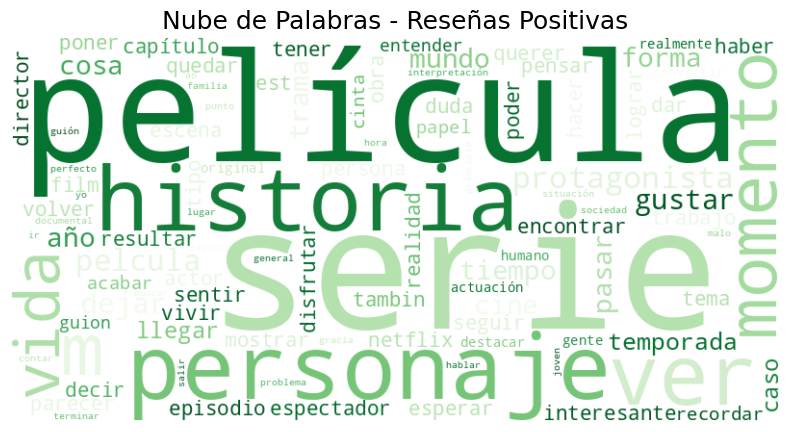

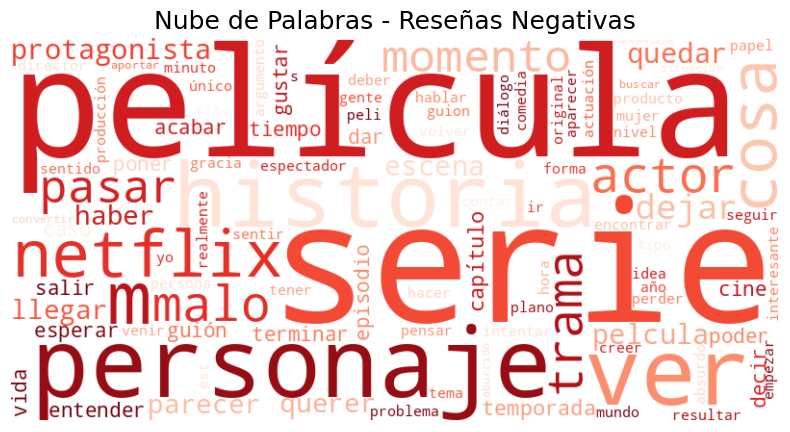

In [10]:
# Se concatenan todos los textos procesados para cada clase
text_positivas = " ".join(df_modelo[df_modelo['Label'] == 1]['Reseña_procesada'])
text_negativas = " ".join(df_modelo[df_modelo['Label'] == 0]['Reseña_procesada'])

# Crear una lista de stopwords extra para asegurar limpieza total
stopwords_extra = {'él', 'ella', 'ellos', 'ellas', 'usted', 'ustedes', 'nosotros', 'vosotros'}

# Función para Generar y Mostrar Nubes
def generate_wordcloud(text, title, color_map='viridis'):
    wordcloud = WordCloud(
        width=800, height=400,
        background_color='white',
        max_words=100,
        contour_width=3,
        contour_color='steelblue',
        colormap=color_map,
        stopwords=stopwords_extra
    ).generate(text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(title, fontsize=18)
    plt.show()

print("--- Nubes de Palabras ---")
# Nube para Reseñas Positivas (Label = 1)
generate_wordcloud(text_positivas, 'Nube de Palabras - Reseñas Positivas', color_map='Greens')

# Nube para Reseñas Negativas (Label = 0)
generate_wordcloud(text_negativas, 'Nube de Palabras - Reseñas Negativas', color_map='Reds')

En las reseñas **positivas**, destacan palabras como *“personaje”, “serie”, “película”, “historia” y “ver”*, lo que sugiere que los usuarios valoran especialmente el desarrollo de los personajes y la calidad narrativa. La presencia de términos como “disfrutar”, “gustar”, “momento”, “vida” o “lograr” refleja una percepción emocional positiva, asociada con la conexión afectiva y la satisfacción generada por las tramas y sus protagonistas.

En las reseñas **negativas**, las palabras más frecuentes —“película”, “personaje”, “serie”, “historia” y “trama”— muestran que los mismos elementos narrativos son también los principales motivos de crítica cuando no cumplen las expectativas. Voces como “malo”, “aburrido”, “plano”, “problema” o “deber” evidencian descontento con el guion o la ejecución narrativa.

En conjunto, el análisis revela que tanto en reseñas positivas como negativas, los aspectos narrativos y de caracterización son los factores más determinantes en la evaluación de películas y series. Mientras que las opiniones positivas se asocian con experiencias satisfactorias y bien desarrolladas, las negativas apuntan a deficiencias en la profundidad de los personajes o la coherencia del guion

#### **2. N-gramas**


--- Análisis de Bigramas ---


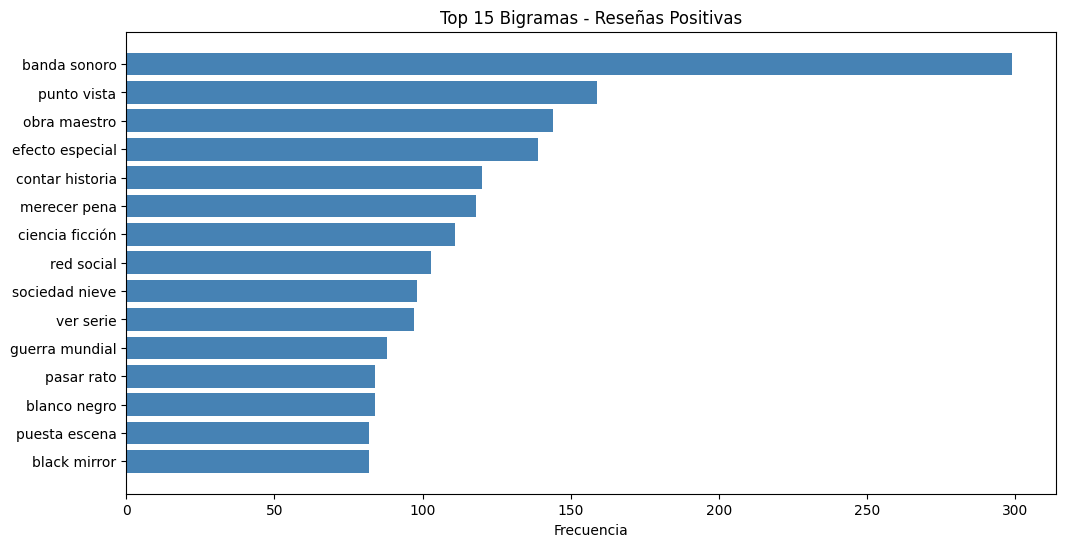

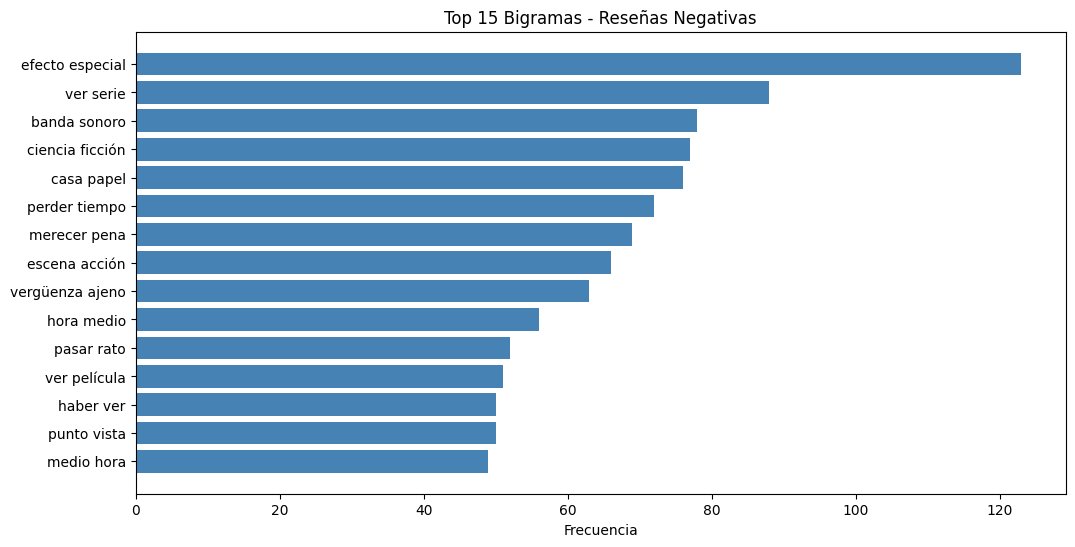

In [11]:
# Función para extraer n-gramas
def extract_ngrams_spacy(text_series, n=2, top_k=15):
    """
    Extrae los n-gramas más frecuentes a partir de una serie de textos ya procesados.
    """
    all_tokens = []

    # 1. Generar lista de tokens (ya lematizados y sin stopwords)
    for text in text_series:
        if isinstance(text, str):
            tokens = [t for t in text.split() if len(t) > 2]  # Excluir palabras cortas
            all_tokens.extend(tokens)

    # 2. Crear tuplas de n palabras consecutivas
    ngrams = [tuple(all_tokens[i:i + n]) for i in range(len(all_tokens) - n + 1)]

    # 3. Contar frecuencia y devolver los más comunes
    counter = Counter(ngrams)
    return counter.most_common(top_k)

# Función para graficar los n-gramas
def plot_ngrams(ngrams, title):
    """
    Visualiza los n-gramas más comunes en un gráfico de barras.
    """
    if not ngrams:
        print(f"No se encontraron n-gramas para: {title}")
        return

    df_ngrams = pd.DataFrame(ngrams, columns=['N-grama', 'Frecuencia'])
    df_ngrams['N-grama'] = df_ngrams['N-grama'].apply(lambda x: ' '.join(x))

    plt.figure(figsize=(12, 6))
    plt.barh(df_ngrams['N-grama'], df_ngrams['Frecuencia'], color='steelblue')
    plt.xlabel('Frecuencia')
    plt.title(title)
    plt.gca().invert_yaxis()  # Pone el más frecuente arriba
    plt.show()

# Análisis de Bigramas
print("\n--- Análisis de Bigramas ---")

# Bigramas en reseñas positivas
ngrams_pos = extract_ngrams_spacy(df_modelo[df_modelo['Label'] == 1]['Reseña_procesada'], n=2, top_k=15)
plot_ngrams(ngrams_pos, 'Top 15 Bigramas - Reseñas Positivas')

# Bigramas en reseñas negativas
ngrams_neg = extract_ngrams_spacy(df_modelo[df_modelo['Label'] == 0]['Reseña_procesada'], n=2, top_k=15)
plot_ngrams(ngrams_neg, 'Top 15 Bigramas - Reseñas Negativas')


El análisis de los Bigramas permite identificar combinaciones frecuentes de palabras que reflejan patrones lingüísticos y temáticos más ricos que el análisis de términos individuales.

En las **reseñas positivas**, destacan expresiones como *“obra maestro”, “efecto especial”, “contar historia”, “merecer pena” y “ciencia ficción”*, las cuales evidencian la apreciación del público hacia la calidad técnica, la narrativa bien desarrollada y los géneros atractivos. Frases como *“red social”* o *“sociedad nieve”* también sugieren que los usuarios valoran producciones con contenido social o reflexivo.

Por otro lado, en las reseñas negativas, aparecen combinaciones como *“efecto especial”, “ver serie”, “perder tiempo”, “vergüenza ajeno” y “malo guion”*, que reflejan frustración o decepción con la ejecución de la serie o película. Frases como *“medio hora”* o *“pasar rato”* aluden a una experiencia poco satisfactoria o aburrida, mientras que *“banda sonoro”* o *“ciencia ficción”* pueden indicar críticas a aspectos técnicos o de género que no cumplieron expectativas.

En conjunto, los bigramas confirman que las reseñas positivas se asocian a experiencias gratificantes, valorando la calidad artística y narrativa, mientras que las negativas expresan insatisfacción con la trama, el ritmo o la producción audiovisual, reforzando las conclusiones obtenidas en el análisis de las nubes de palabras.

## **Etapa 2: Vectorización y Entrenamiento de Modelos**

En esta segunda etapa, se inicia la fase de representación numérica de los textos y el entrenamiento de modelos supervisados para la clasificación de sentimientos.
El objetivo principal es transformar las reseñas procesadas en vectores que puedan ser comprendidos por algoritmos de Machine Learning y Deep Learning.

Para ello, se aplican las siguientes técnicas:

*   **Bag of Words (BoW):** Representación basada en la frecuencia de las palabras.
*   **TF-IDF (Term Frequency - Inverse Document Frequency):** Representación que pondera la importancia de los términos considerando su frecuencia en el corpus.
*   **Text to Sequence (Keras):** Vectorización para modelos de Deep Learning.





###**Etapa 2.1: Preparación de los Datos para Modelado**

Previo al proceso de vectorización, se procede a definir las variables que serán utilizadas para el modelado.
La variable **X** contendrá los textos ya procesados lingüísticamente (*Reseña_procesada*), mientras que **Y** representará la variable objetivo (*Label*), la cual identifica el sentimiento de cada reseña (1 = Positiva, 0 = Negativa).

In [12]:
# Definición de variables predictoras y objetivo
X = df_modelo['Reseña_procesada']
y = df_modelo['Label']

# Verificación de dimensiones y distribución de la variable objetivo
print("Dimensión total del dataset:", X.shape[0])
print("Distribución de clases:")
display(y.value_counts(normalize=True).round(3))

Dimensión total del dataset: 6292
Distribución de clases:


,proportion
Label,
1,0.599
0,0.401


### **ETAPA 2.2: División del conjunto de datos (Train / Test)**
Se realiza una partición del conjunto de datos en conjunto de entrenamiento y conjunto de prueba para evaluar el rendimiento del modelo en datos no vistos.
Se utiliza una separación estratificada para mantener la misma proporción de clases (Label) en ambos subconjuntos y evitar sesgos en la evaluación.

In [13]:
RANDOM_STATE = 42
TEST_SIZE = 0.2  # 20% para prueba, 80% para entrenamiento

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
    stratify=y
)

# Verificaciones
print("Registros totales:", len(X))
print("Train:", len(X_train), "  Test:", len(X_test))
print("\nDistribución en TRAIN (proporción):")
display(y_train.value_counts(normalize=True).round(3))
print("\nDistribución en TEST (proporción):")
display(y_test.value_counts(normalize=True).round(3))

Registros totales: 6292
Train: 5033   Test: 1259

Distribución en TRAIN (proporción):


,proportion
Label,
1,0.598
0,0.402



Distribución en TEST (proporción):


,proportion
Label,
1,0.599
0,0.401


El conjunto total contiene **6292 registros**, de los cuales se asignan **5033** al entrenamiento (80%) y **1259** al conjunto de prueba (20%).
La división estratificada permite mantener el equilibrio de clases observado originalmente en el dataset. En este caso, las proporciones se conservaron casi idénticas:

**Entrenamiento**
*   Label= 1: 0.598
*   Label = 0: 0.402

**Prueba**
*   Label= 1: 0.599
*   Label = 0: 0.401

Esto asegura que tanto el modelo como las evaluaciones posteriores representen adecuadamente la distribución real de las reseñas positivas y negativas.
Además, se fijó una semilla (random_state=42) para garantizar la reproducibilidad de los resultados.




### **ETAPA 2.3: Vectorización del texto**
En esta etapa se convierten las reseñas procesadas en representaciones numéricas que puedan ser interpretadas por los modelos de Machine Learning.
Se aplican dos técnicas clásicas de vectorización:
*   **Bag of Words (BoW):** cuenta la frecuencia de aparición de las palabras.
*   **TF-IDF (Term Frequency – Inverse Document Frequency):** pondera las palabras según su frecuencia en cada documento y en el conjunto total, destacando las más relevantes.


In [14]:
# --- Bag of Words ---
vectorizer_bow = CountVectorizer(max_features=5000)
X_train_bow = vectorizer_bow.fit_transform(X_train)
X_test_bow = vectorizer_bow.transform(X_test)

# --- TF-IDF ---
vectorizer_tfidf = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer_tfidf.fit_transform(X_train)
X_test_tfidf = vectorizer_tfidf.transform(X_test)

print("Dimensión BoW:", X_train_bow.shape)
print("Dimensión TF-IDF:", X_train_tfidf.shape)

Dimensión BoW: (5033, 5000)
Dimensión TF-IDF: (5033, 5000)


Ambas técnicas limitan el número máximo de características a 5000 términos más frecuentes para reducir la dimensionalidad y evitar el sobreajuste.

El resultado indica que el conjunto de entrenamiento contiene 5033 reseñas representadas mediante 5000 características cada una.

### **ETAPA 2.4 — Entrenamiento del modelo (Regresión Logística)**

Una vez vectorizados los textos, se entrenó un modelo de clasificación supervisada para predecir el sentimiento de las reseñas.
Como modelo base se utilizó la Regresión Logística, una técnica lineal ampliamente usada en análisis de texto por su eficiencia y capacidad para manejar datos de alta dimensión.

In [15]:
# --- Modelo con Bag of Words ---
modelo_bow = LogisticRegression(max_iter=1000, random_state=42)
modelo_bow.fit(X_train_bow, y_train)
y_pred_bow = modelo_bow.predict(X_test_bow)

# --- Modelo con TF-IDF ---
modelo_tfidf = LogisticRegression(max_iter=1000, random_state=42)
modelo_tfidf.fit(X_train_tfidf, y_train)
y_pred_tfidf = modelo_tfidf.predict(X_test_tfidf)

# --- Evaluación ---
print("Resultados con Bag of Words")
print("Accuracy:", accuracy_score(y_test, y_pred_bow))
print(classification_report(y_test, y_pred_bow))

print("\nResultados con TF-IDF")
print("Accuracy:", accuracy_score(y_test, y_pred_tfidf))
print(classification_report(y_test, y_pred_tfidf))

Resultados con Bag of Words
Accuracy: 0.8332009531374106
              precision    recall  f1-score   support

           0       0.79      0.79      0.79       505
           1       0.86      0.86      0.86       754

    accuracy                           0.83      1259
   macro avg       0.83      0.83      0.83      1259
weighted avg       0.83      0.83      0.83      1259


Resultados con TF-IDF
Accuracy: 0.8498808578236696
              precision    recall  f1-score   support

           0       0.88      0.73      0.80       505
           1       0.84      0.93      0.88       754

    accuracy                           0.85      1259
   macro avg       0.86      0.83      0.84      1259
weighted avg       0.85      0.85      0.85      1259





*   **Bag of Words (BoW):**
El modelo basado en Bag of Words alcanzó una **exactitud del 83.3%**, mostrando un desempeño equilibrado entre reseñas positivas y negativas, con una ligera ventaja en la predicción de opiniones positivas (Label = 1).
Las métricas de precisión, recall y F1-score se mantienen consistentes alrededor de 0.83, lo que evidencia una buena capacidad del modelo para capturar patrones básicos en el texto sin información contextual adicional.
*   **TF-IDF:**
El modelo con TF-IDF logró una **exactitud del 84.9%**, superando ligeramente al enfoque BoW.
Esta mejora se debe a que TF-IDF pondera las palabras según su importancia dentro del corpus, reduciendo el peso de términos muy frecuentes y resaltando aquellos más representativos.
Aunque el recall para la clase negativa (0.73) es menor, el modelo generaliza bien con un F1-score promedio cercano a 0.85, mostrando una mejor diferenciación entre reseñas positivas y negativas.

El modelo basado en TF-IDF supera ligeramente al de Bag of Words, confirmando que el uso de ponderaciones según la relevancia de cada término mejora la capacidad predictiva.
Ambos enfoques alcanzan métricas sólidas para un modelo base, evidenciando que las reseñas procesadas contienen patrones lingüísticos claramente diferenciables entre opiniones positivas y negativas.
Estos resultados constituyen una base sólida antes de avanzar hacia los modelos de Deep Learning, donde se busca capturar dependencias contextuales más complejas mediante secuencias de texto y redes neuronales recurrentes (LSTM).

### **ETAPA 2.5 — Matriz de Confusión y Evaluación Visual**

Para complementar las métricas obtenidas con Accuracy, Precision, Recall y F1-score, se generaron las matrices de confusión de ambos modelos (Bag of Words y TF-IDF).
Estas matrices permiten visualizar el desempeño del clasificador, mostrando cuántas reseñas positivas y negativas fueron correctamente o incorrectamente clasificadas.

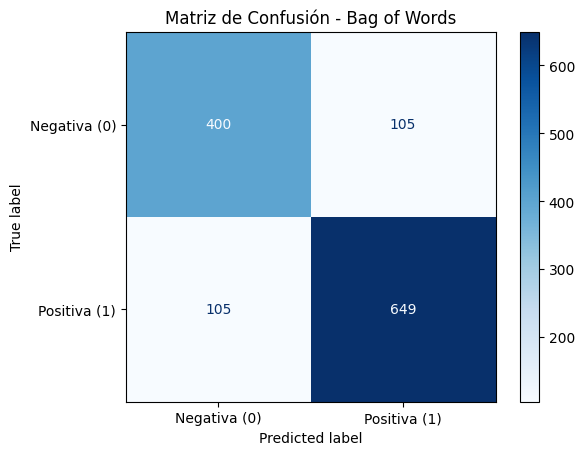

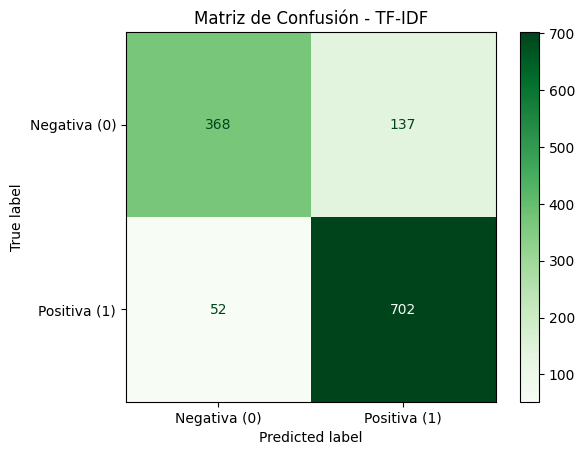

In [16]:
# Matriz de confusión para Bag of Words
cm_bow = confusion_matrix(y_test, y_pred_bow)
disp_bow = ConfusionMatrixDisplay(confusion_matrix=cm_bow, display_labels=['Negativa (0)', 'Positiva (1)'])
disp_bow.plot(cmap='Blues')
plt.title("Matriz de Confusión - Bag of Words")
plt.show()

# Matriz de confusión para TF-IDF
cm_tfidf = confusion_matrix(y_test, y_pred_tfidf)
disp_tfidf = ConfusionMatrixDisplay(confusion_matrix=cm_tfidf, display_labels=['Negativa (0)', 'Positiva (1)'])
disp_tfidf.plot(cmap='Greens')
plt.title("Matriz de Confusión - TF-IDF")
plt.show()

**Bag of Words (BoW):**
*   El modelo clasificó correctamente **400 reseñas negativas** y **649 positivas.**
*   Se observa un número equilibrado de errores: **105 falsos positivos** (reseñas negativas clasificadas como positivas) y **105 falsos negativos** (positivas clasificadas como negativas).
*   Esto indica que el modelo mantiene un desempeño estable en ambas clases, aunque aún confunde algunos textos con expresiones ambiguas o neutras.

**TF-IDF:**
*   Muestra una mejora clara en comparación con BoW, especialmente en la clase positiva.
*   Clasificó correctamente **702 reseñas positivas** y **368 negativas**.
*   El número de falsos negativos se redujo considerablemente (**52** frente a los **105** de BoW), lo que demuestra una mejor capacidad del modelo para reconocer sentimientos positivos.
*   Aun así, el modelo tiende ligeramente a sobreclasificar como positivas, evidenciado por los **137 falsos positivos**.

El análisis visual confirma los resultados numéricos obtenidos:


*   **TF-IDF + Regresión Logística** es el modelo más robusto, alcanzando una mejor capacidad de generalización y reduciendo los errores en la identificación del sentimiento positivo.
*   El modelo **BoW** ofrece un rendimiento competitivo, pero con menor sensibilidad hacia las reseñas positivas.
*   En general, ambos modelos capturan adecuadamente los patrones lingüísticos principales del dataset, validando la eficacia del preprocesamiento realizado en la Etapa 1.

### **ETAPA 2.6 — Deep Learning: Text to Sequence con Keras**

En esta etapa se implementa un modelo de Deep Learning para análisis de sentimiento usando redes neuronales.
A diferencia de los métodos tradicionales (Bag of Words o TF-IDF), Keras permite transformar el texto en secuencias de enteros y aprovechar representaciones densas a través de embeddings, capturando relaciones semánticas más profundas entre las palabras.

#### **1. Tokenización y preparación de secuencias**

En esta primera fase:

*   Se crea un tokenizador que asigna un número entero a cada palabra del vocabulario.
*   Cada reseña se convierte en una secuencia de enteros.
*   Luego, todas las secuencias se ajustan a la misma longitud (100 palabras) mediante padding, requisito para alimentar una red neuronal.
*   Este proceso prepara los datos para entrenar un modelo de embeddings y capas densas que puedan aprender patrones complejos en el texto.

In [17]:
# Parámetros
MAX_WORDS = 5000     # máximo número de palabras en el vocabulario
MAX_LEN = 100         # longitud máxima de las secuencias

# Tokenizador
tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

# Transformar textos a secuencias
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Rellenar (padding) para igualar longitudes
X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_LEN, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=MAX_LEN, padding='post', truncating='post')

print("Dimensión del vocabulario:", len(tokenizer.word_index))
print("Forma de X_train_pad:", X_train_pad.shape)

Dimensión del vocabulario: 50617
Forma de X_train_pad: (5033, 100)


Esto indica que el modelo detectó *50617 palabras única*s en el corpus, aunque el tokenizador usará solo las **5000 más frecuentes** (definidas en MAX_WORDS) para optimizar el rendimiento.
Cada reseña del conjunto de entrenamiento se representa ahora como una **secuencia de 100 enteros**, donde cada número corresponde a una palabra del vocabulario.

Este formato estructurado es el que se utilizará como entrada para el modelo de Deep Learning, que aprenderá representaciones densas de las palabras mediante embeddings y relaciones entre ellas.

#### **2. Entrenamiento del modelo de clasificación**

En esta etapa se entrena un modelo de aprendizaje profundo con el objetivo de predecir la polaridad de las reseñas (positivas o negativas) a partir de las secuencias numéricas generadas en el paso anterior.

Para ello, se emplea una **red LSTM (Long Short-Term Memory)**, un tipo de red neuronal recurrente especialmente útil para procesar texto, ya que permite conservar información contextual relevante a lo largo de la secuencia.

In [18]:
# Parámetros del modelo
vocab_size = 50617   # tamaño del vocabulario
embedding_dim = 100  # dimensión de los vectores de embedding
max_length = 100     # longitud máxima de las secuencias

# Definición del modelo
model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length),
    LSTM(128, dropout=0.2, recurrent_dropout=0.2),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # salida binaria (positivo / negativo)
])

# Compilación del modelo
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

# Entrenamiento del modelo
history = model.fit(
    X_train_pad, y_train,
    epochs=15,
    batch_size=64,
    validation_split=0.2,
    verbose=1
)

# Evaluación del modelo
loss, accuracy = model.evaluate(X_train_pad, y_train, verbose=0)
print(f"Exactitud en entrenamiento: {accuracy:.4f}")

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 34s 341ms/step - accuracy: 0.5783 - loss: 0.6793 - val_accuracy: 0.6087 - val_loss: 0.6690
Epoch 2/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 36s 337ms/step - accuracy: 0.5945 - loss: 0.6600 - val_accuracy: 0.6087 - val_loss: 0.6480
Epoch 3/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 48s 457ms/step - accuracy: 0.5976 - loss: 0.5969 - val_accuracy: 0.6038 - val_loss: 0.6709
Epoch 4/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 21s 336ms/step - accuracy: 0.6488 - loss: 0.5598 - val_accuracy: 0.6077 - val_loss: 0.6710
Epoch 5/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 20s 322ms/step - accuracy: 0.6854 - loss: 0.5135 - val_accuracy: 0.5541 - val_loss: 0.7641
Epoch 6/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 21s 340ms/step - accuracy: 0.6879 - loss: 0.4588 - val_accuracy: 0.6236 - val_loss: 0.7834
Epoch 7/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 22s 353ms/step - accuracy: 0.6845 - loss: 0.4596 - val_accuracy: 0.6256 - val_loss: 1.0415
Epoch 8/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 21s 341ms/step - accuracy: 0.7248 - loss: 0.4585 - val_accu

Durante el entrenamiento, el modelo muestra una mejora progresiva de la exactitud en las primeras épocas, alcanzando un valor final de **0.93 en entrenamiento** y alrededor de **0.77 en validación**.

Esto indica que la red logra aprender patrones relevantes del texto, aunque presenta una ligera tendencia al sobreajuste en las últimas épocas, ya que la exactitud de entrenamiento continúa mejorando mientras que la validación se estabiliza.

En términos generales, el modelo LSTM demuestra una capacidad sólida para capturar relaciones contextuales y dependencias secuenciales en las reseñas, superando a los enfoques clásicos basados en frecuencia de palabras (Bag of Words y TF-IDF).
Sin embargo, este rendimiento implica un mayor costo computacional y una mayor sensibilidad al sobreajuste, lo que podría mitigarse aplicando estrategias como early stopping, regularización adicional o ajuste de hiperparámetros.

#### **3. Evaluación del modelo y visualización de resultados**

Pérdida en test: 0.7312
Exactitud en test: 0.7919


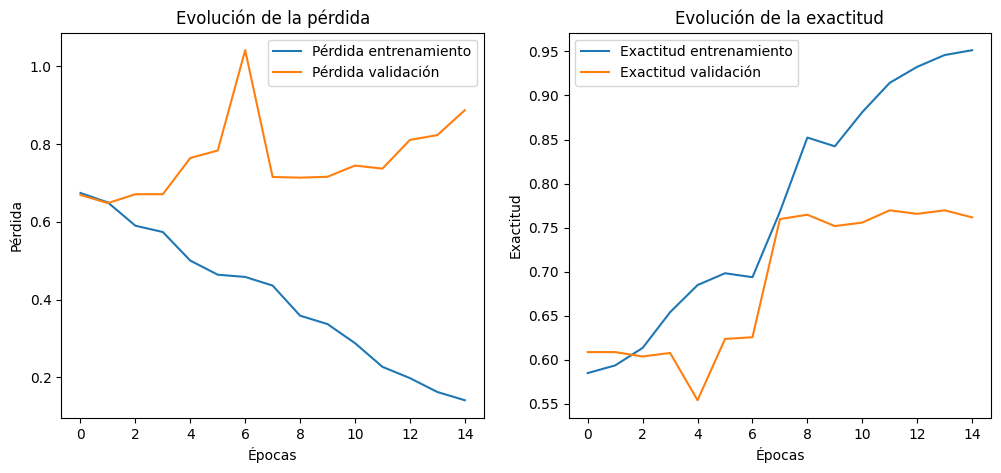

In [25]:
# Evaluar el modelo en los datos de prueba
loss, accuracy = model.evaluate(X_test_pad, y_test, verbose=0)
print(f"Pérdida en test: {loss:.4f}")
print(f"Exactitud en test: {accuracy:.4f}")

# Visualizar las curvas de pérdida y exactitud
plt.figure(figsize=(12, 5))

# Curva de pérdida
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Pérdida entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida validación')
plt.title('Evolución de la pérdida')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()

# Curva de exactitud
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Exactitud entrenamiento')
plt.plot(history.history['val_accuracy'], label='Exactitud validación')
plt.title('Evolución de la exactitud')
plt.xlabel('Épocas')
plt.ylabel('Exactitud')
plt.legend()

plt.show()

El modelo LSTM fue evaluado utilizando el conjunto de prueba, obteniendo una **pérdida de 0.7312** y una **exactitud del 79.19%**, lo que refleja un desempeño satisfactorio en la clasificación de reseñas según su polaridad.

En la evolución de las métricas durante el entrenamiento, se observa que la **exactitud de entrenamiento** aumenta de forma progresiva hasta alcanzar aproximadamente **0.95**, mientras que la **exactitud de validación** se estabiliza alrededor de **0.77–0.79**. Este comportamiento indica que el modelo logra aprender patrones relevantes del texto, aunque presenta una ligera tendencia al sobreajuste, evidenciada por la brecha entre ambas curvas.

Por su parte, la **pérdida de entrenamiento** disminuye de manera continua, mientras que la **pérdida de validación** muestra fluctuaciones y un incremento leve a partir de la séptima época. Este fenómeno sugiere que el modelo comienza a memorizar los datos de entrenamiento después de ese punto, reduciendo parcialmente su capacidad de generalización.

A pesar de ello, el rendimiento alcanzado en el conjunto de prueba demuestra que la red LSTM es capaz de capturar relaciones contextuales y semánticas en el texto con un nivel de precisión superior al que ofrecen métodos tradicionales basados en frecuencias de palabras, como Bag of Words o TF-IDF.

## **Análisis comparativo y conclusiones finales**

###**Comparación general de modelos**

1.   **Regresión Logística con Bag of Words (BoW)**

   *   Accuracy en test: 0.83
   *   Observaciones: El modelo muestra un desempeño equilibrado entre clases. Sin embargo, su representación basada solo en la frecuencia de palabras limita la comprensión del contexto.

2.   **Regresión Logística con TF-IDF**
   *   Accuracy en test: 0.85
   *   Observaciones: Mejora el rendimiento respecto al modelo BoW al ponderar la relevancia de las palabras. Muestra un buen equilibrio entre precisión y recall, capturando mejor los patrones del texto.

3.   **Modelo LSTM con embeddings (Keras)**
   *   Accuracy en test: 0.79
   *   Observaciones: Capta relaciones contextuales entre palabras y logra buena generalización. Sin embargo, presenta un ligero sobreajuste, ya que la exactitud de entrenamiento (0.95) es considerablemente mayor que la de validación (0.77).




###**Reflexión sobre los resultados**

El proyecto demuestra cómo la elección de la representación textual influye directamente en la capacidad del modelo para clasificar opiniones.
En la etapa inicial, los enfoques clásicos basados en** Bag of Words (BoW)** y **TF-IDF** lograron resultados consistentes al identificar correctamente la polaridad de las reseñas. Estos métodos mostraron que las palabras con mayor frecuencia y peso TF-IDF estaban estrechamente relacionadas con emociones positivas o negativas, lo que permitió identificar patrones claros de lenguaje.

El modelo **LSTM**, en cambio, introdujo una ventaja cualitativa importante al aprender dependencias temporales y contextuales entre palabras, lo que le permitió interpretar mejor frases largas, ironías o matices emocionales que los métodos tradicionales no captan.
Sin embargo, su desempeño (exactitud del 79.19 % y pérdida de 0.7312) no superó significativamente al de TF-IDF, probablemente debido al tamaño del dataset y al número limitado de épocas, factores que favorecen un ligero sobreajuste.

A nivel general, se evidenció que el conjunto de reseñas presentaba una mayor proporción de opiniones positivas, con un vocabulario caracterizado por términos emocionales asociados a satisfacción y recomendación, mientras que las reseñas negativas contenían expresiones más directas, críticas y con mayor carga subjetiva.
Estos patrones confirman la coherencia semántica del dataset y validan la efectividad de los modelos empleados para distinguir entre polaridades opuestas del lenguaje.

### **Proyección y mejoras futuras**

Para optimizar el desempeño y reducir el sobreajuste, podrían implementarse las siguientes estrategias:

*   Ampliar el dataset o aplicar técnicas de data augmentation textual (sinonimización, traducción inversa, generación por LLMs).
*   Incorporar embeddings preentrenados como Word2Vec, GloVe o BETO/BERT español, para enriquecer la representación semántica.
*   Ajustar hiperparámetros (número de neuronas, tasa de dropout, tamaño del lote, longitud de secuencia) mediante validación cruzada.
*   Implementar Early Stopping y Regularización L2 para mejorar la capacidad de generalización.
*   Explorar arquitecturas más avanzadas como Bidirectional LSTM o GRU.

### **Conclusión general**

El proyecto permitió abordar de forma integral el análisis de sentimiento de reseñas en español, aplicando técnicas de Procesamiento de Lenguaje Natural (NLP) y métodos de aprendizaje automático y profundo.

En la **Etapa 1**, se llevó a cabo un riguroso proceso de limpieza y preparación del texto, que incluyó la lectura del dataset, eliminación de símbolos y puntuación, tokenización, conversión a minúsculas, remoción de stopwords y lematización.
Posteriormente, se generaron nubes de palabras y n-gramas, que permitieron identificar los términos más representativos de cada tipo de reseña. El análisis de sentimiento evidenció una mayor proporción de opiniones positivas, con vocabulario asociado a satisfacción y recomendación, mientras que las reseñas negativas presentaron un lenguaje más directo y crítico. Estos hallazgos reflejan una clara diferenciación emocional y semántica en el corpus.

En la **Etapa 2**, se implementaron modelos de vectorización y clasificación, combinando enfoques de Machine Learning (TF-IDF y Bag of Words) con un modelo de Deep Learning basado en LSTM mediante Text to Sequence de Keras.
Los métodos clásicos lograron resultados sólidos, especialmente TF-IDF + Regresión Logística, destacando por su eficiencia y simplicidad. Por su parte, la red LSTM aportó una ventaja cualitativa al capturar dependencias contextuales y temporales entre palabras, aunque su rendimiento final se vio limitado por el tamaño del dataset y la cantidad de épocas de entrenamiento, lo que generó un leve sobreajuste.

En conjunto, el trabajo demuestra la eficacia de combinar técnicas tradicionales de NLP con modelos neuronales para obtener una comprensión más profunda del comportamiento lingüístico y emocional de los usuarios.
Además, sienta las bases para el desarrollo de futuros sistemas de análisis automatizado de opiniones en español, aplicables en ámbitos como la experiencia del cliente, el análisis de productos y la reputación digital.